# DSCI 100-Group Project : Predicting Type 2 Diabetes
Bhavya Mohan, Jason Jonathan, Sherin X, Neha Menon

Introduction: 


Methods/Results:

Discussion:

In [1]:
# Loading Packages ----
library(ggplot2)
library(dplyr)
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)
library(gridExtra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks pur

In [4]:
# Load data ----

## CLASS refers to diabetes where n is no diabetes, y is diabetic, and p is poteintially diabetic

url <- "https://raw.githubusercontent.com/jasonj17/DSCI100Project/main/Dataset%20of%20Diabetes%20.csv"
data <- read_csv(url)|>
    mutate(CLASS = as_factor(CLASS))

### Data is already in Tidy Format

Rows: 1000 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Gender, CLASS
dbl (12): ID, No_Pation, AGE, Urea, Cr, HbA1c, Chol, TG, HDL, LDL, VLDL, BMI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
#### Make the training data
set.seed(1035)

data_split <- initial_split(data, prop = 0.75, strata = CLASS)  
data_train <- training(data_split)   
data_test <- testing(data_split)


In [6]:
data_recipe <- recipe(CLASS ~ BMI + HbA1c, data = data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())


In [7]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

data_vfold <- vfold_cv(data_train, v = 10, strata = CLASS)


knn_results <- workflow() |>
       add_recipe(data_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = data_vfold, grid = 10) |>
       collect_metrics()

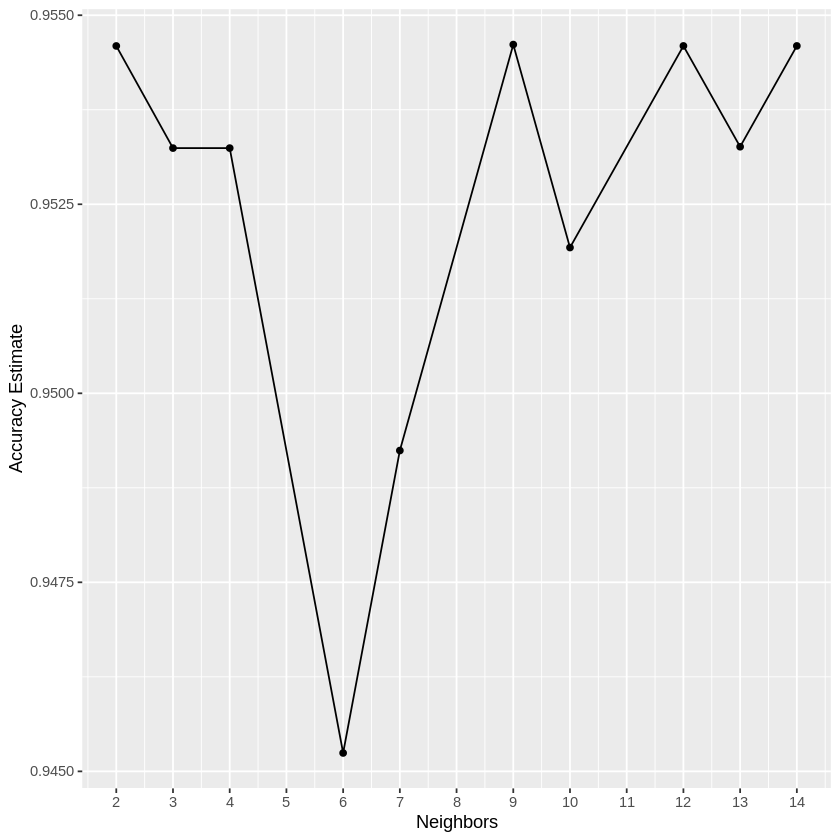

In [8]:
accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 20, by = 1))
accuracy_versus_k

In [9]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
  set_engine("kknn") |>
  set_mode("classification")

In [10]:
best_fit <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = data_train)

In [11]:
data_predictions <- predict(best_fit, data_test) |> 
    bind_cols(data_test)

In [12]:
data_acc <- data_predictions |> 
    metrics(truth = CLASS, estimate = .pred_class) |> 
    select(.metric, .estimate)|>
    head(1)
data_acc

.metric,.estimate
<chr>,<dbl>
accuracy,0.9561753


In [13]:
data_cm <- data_predictions |> 
    conf_mat(truth = CLASS, estimate = .pred_class)
data_cm

          Truth
Prediction   N   P   Y
         N  27   1   9
         P   0  12   0
         Y   1   0 201

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'CLASS' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capture.output(print(o

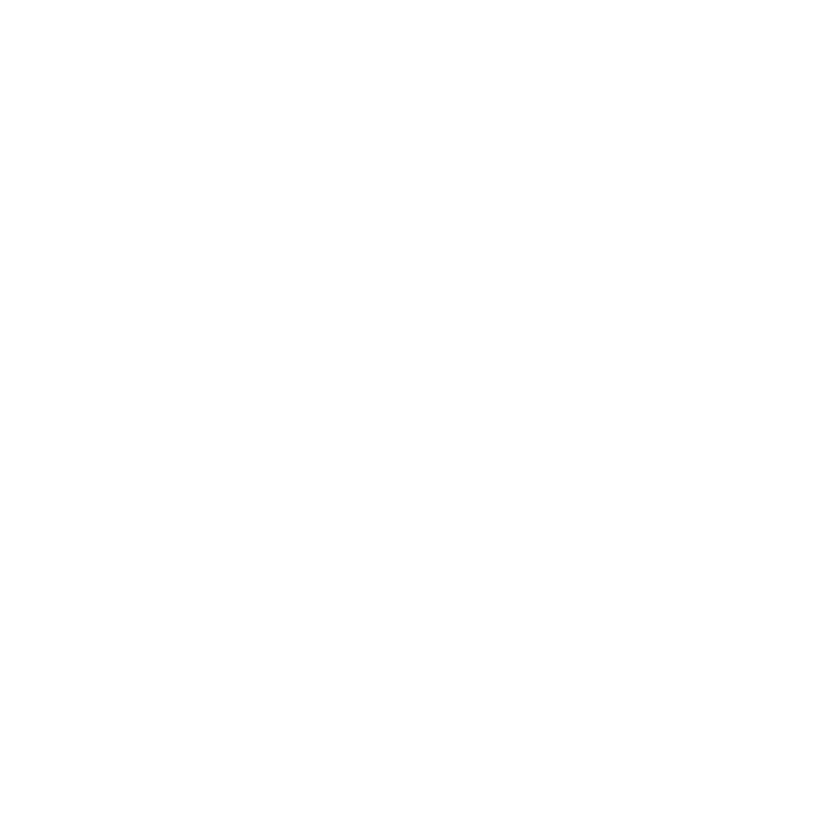

In [14]:
bmi_grid <- seq(min(data$BMI), 
                max(data$BMI), 
                length.out = 100)
HbA_grid <- seq(min(data$HbA1c), 
                max(data$HbA1c), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(BMI = bmi_grid, 
                                HbA1c = HbA_grid))


# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(best_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(Class = .pred_class)


wkflw_plot <- ggplot() +
  geom_point(data = data_train, 
             mapping = aes(x = BMI, 
                           y = HbA1c, 
                           color = CLASS), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = BMI, 
                           y = HbA1c, 
                           color = CLASS), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Diagnosis", 
       x = "BMI (standardized)", 
       y = "BMI (standardized)") +
  scale_color_manual(labels = c("Malignant", "Benign", "Unknown"), 
                     values = c("orange2", "steelblue2", "red")) +
  theme(text = element_text(size = 12))

wkflw_plot